In [7]:
import datetime
import os
import warnings
from typing import List

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

warnings.filterwarnings("ignore")


## 1. Data Configuration

In [8]:
DATA_ROOT_FOLDER = '/home/meow/Desktop/internship-speedrun/bcdc_ds_takehome/data'


In [9]:
TFL_CYCLE_HIRES_DATA_FILENAME = 'tfl-daily-cycle-hires.xlsx'
ELECTRICAL_POWER_DATA_FILENAME = 'electrical_power_data.csv'
BANK_HOLIDAYS_FILENAME = 'ukbankholidays.csv'

In [10]:
## Cycle hires data
CYCLE_HIRES_EXCEL_SHEET_NAME = 'Data'  # input sheet that contains data

# input columns for main timeseries with daily hires 
DAY_COL = 'Day'
DAILY_HIRED_BICYCLES_COL = 'Number of Bicycle Hires'

# input columns for meta-info with hiring time
MONTHLY_AVG_MONTH_INP_COL = 'Month.1'
MONTH_COL = 'Month'  # alias for col above (rename)
AVG_HIRE_TIME_COL = 'Average Hire Time (mins)'


#-----------------------
## Electrical power data
SETTLEMENT_DATE_COL = 'SD'  # input col with date

# Electricity Generation sources, input column names
GAS_COL = 'Gas'
COAL_COL = 'Coal'
NUCLEAR_COL = 'Nuclear'
HYDRO_COL = 'Hydro'
PUMPED_HYDRO_COL = 'Net Pumped'
WIND_COL = 'Wind'
GAS_TURBINES_COL = 'OCGT'
OIL_COL = 'Oil'
BIOMASS_COL = 'Biomass'

GEN_SOURCES_LIST = [
    GAS_COL, COAL_COL, NUCLEAR_COL, HYDRO_COL, PUMPED_HYDRO_COL,
    WIND_COL, GAS_TURBINES_COL, OIL_COL, BIOMASS_COL
]

# Electricity Interconnections, input column names
FRENCH_INT_COL = 'French Int'
DUTCH_INT_COL = 'Dutch Int'
MOYLE_INT_COL = 'NI Int'
IRELAND_INT_COL = 'Eire Int'
BELGIUM_INT_COL = 'Nemo Int'

INTERCONNECTIONS_LIST = [
    FRENCH_INT_COL, DUTCH_INT_COL, MOYLE_INT_COL, IRELAND_INT_COL, BELGIUM_INT_COL
]

# total net supply column
TOTAL_NET_SUPPLY_COL = 'Net Supply'


#-----------------------
## UK Bank holidays data
HOLIDAYS_DATE_COL = 'UK BANK HOLIDAYS'  # single input col

## 2. Read data, parse types, drop unnecessary information

In [11]:
tfl_cycle_hires_path = os.path.join(DATA_ROOT_FOLDER, TFL_CYCLE_HIRES_DATA_FILENAME)
electrical_power_path = os.path.join(DATA_ROOT_FOLDER, ELECTRICAL_POWER_DATA_FILENAME)
bank_holidays_path = os.path.join(DATA_ROOT_FOLDER, BANK_HOLIDAYS_FILENAME)

In [12]:
## read cycle hires data
cycle_hires_data_sheet_as_df = pd.read_excel(
    tfl_cycle_hires_path,
    sheet_name=CYCLE_HIRES_EXCEL_SHEET_NAME
)

daily_hires_history_df = (
    cycle_hires_data_sheet_as_df
    [[DAY_COL, DAILY_HIRED_BICYCLES_COL]]
)

monthly_avg_hire_time_df = (
    cycle_hires_data_sheet_as_df
    [[MONTHLY_AVG_MONTH_INP_COL, AVG_HIRE_TIME_COL]]
    .rename({MONTHLY_AVG_MONTH_INP_COL: MONTH_COL}, axis=1)
    .dropna()
)


In [13]:
## read electrical power data
electrical_power_df = (
    pd.read_csv(
        electrical_power_path,
        parse_dates=[SETTLEMENT_DATE_COL]
    )
    .rename({SETTLEMENT_DATE_COL: DAY_COL}, axis=1)
)


def convert_electrical_power_data(
    inp_df: pd.DataFrame,
    cols_to_convert: List[str]
) -> None:
    parse_long_string_to_int = lambda x: int(x.replace(',', ''))
    
    for col in cols_to_convert:
        inp_df[col] = inp_df[col].map(parse_long_string_to_int)

        
convert_electrical_power_data(
    inp_df=electrical_power_df,
    # convert all columns except date (first column) to integers
    cols_to_convert=electrical_power_df.columns[1:]
)

In [14]:
## read holidays data
# parser for UK Bank format (e.g. '4-May-1998', '25-Aug-2110')
uk_bank_dateparser = lambda x: datetime.datetime.strptime(x, '%d-%b-%Y')

uk_holidays_df = pd.read_csv(
    bank_holidays_path,
    date_parser=uk_bank_dateparser,
    parse_dates=[HOLIDAYS_DATE_COL]
)

holiday_dates = set(uk_holidays_df[HOLIDAYS_DATE_COL].values)

## 3. Basic EDA

In [15]:
sns.set_theme(style="darkgrid")
# plt.xkcd();
sns.set(rc={'figure.figsize':(16,8)})

In [16]:
## Additional columns, created in the process
IS_HOLIDAY_COL = 'Is UK holiday'
WEEKDAY_COL = 'Day of week'
YEAR_COL = 'Year'
MONTH_COL = 'Month'
MONTH_NUM_COL = 'Month Number'
SEASON_COL = 'Season'
IS_WEEKEND_COL = 'Is Weekend'

SPECIFIC_YEAR_2019 = 'General vs Specific'
SPECIFIC_YEAR_2020 = 'General vs Specific'

SEASON_SHIFTED_COL = 'Season Shifted'
SEASON_HAS_CHANGED_COL = 'Season changed'
SEASON_DATE_MIDDLE_COL = 'Season Middle Date'

PROPORTION_SUM_YEAR_COL = 'sum'

INTERCONNETCIONS_SUM_COL = 'Interconnections Total Income'

ELECTR_AMOUNT_COL = 'amount'
ELECTR_TYPE_COL = 'type'

### 3.1 A high-level overview of the hires data

Let us start with a high-level overview of the bike hires data. 
On the following plot, we will plot a smoothed (with 7-days moving average) hires data and daily data (because smoothing prevents us from seeing any outliers at least).

In [17]:
daily_hires_history_df.loc[:, f'rolling_7d_{DAILY_HIRED_BICYCLES_COL}'] = (
    daily_hires_history_df
    [DAILY_HIRED_BICYCLES_COL]
    .rolling(window=7)
    .mean()
)

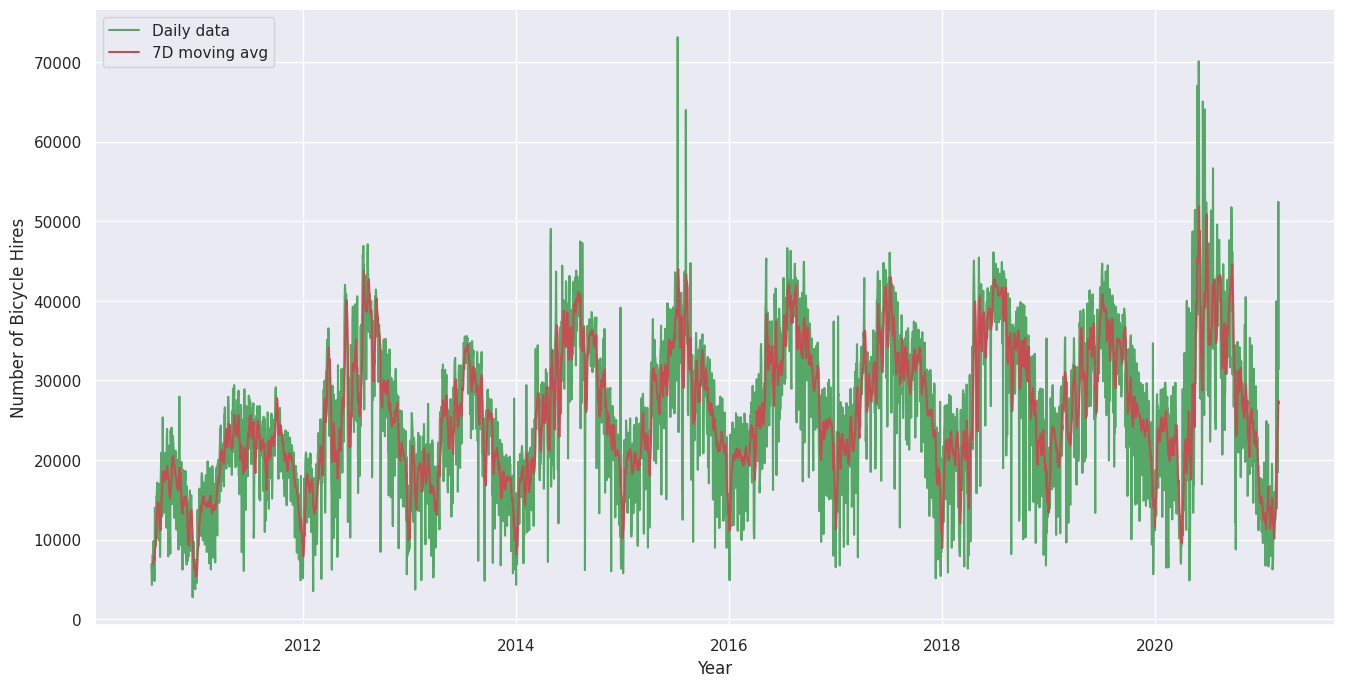

In [18]:
sns.lineplot(x=DAY_COL, y=DAILY_HIRED_BICYCLES_COL, color='g',
             data=daily_hires_history_df, label='Daily data');

sns.lineplot(x=DAY_COL, y=f'rolling_7d_{DAILY_HIRED_BICYCLES_COL}', color='r',
             data=daily_hires_history_df, label='7D moving avg');

plt.xlabel('Year');

There is a clear trend in overall seasonality within a year: more bikes are being used in the times around mid-year (summer) months than the times around New Year. It makes sense - the weather becomes warmer (and probably drier), more people would use bicycles.

It is easy to notice several plot peaks (in 2015 and 2020), covering them later.

Let's infer seasonality from the data more straightforward and check the general trend with simple StatsModels seasonal decompose.

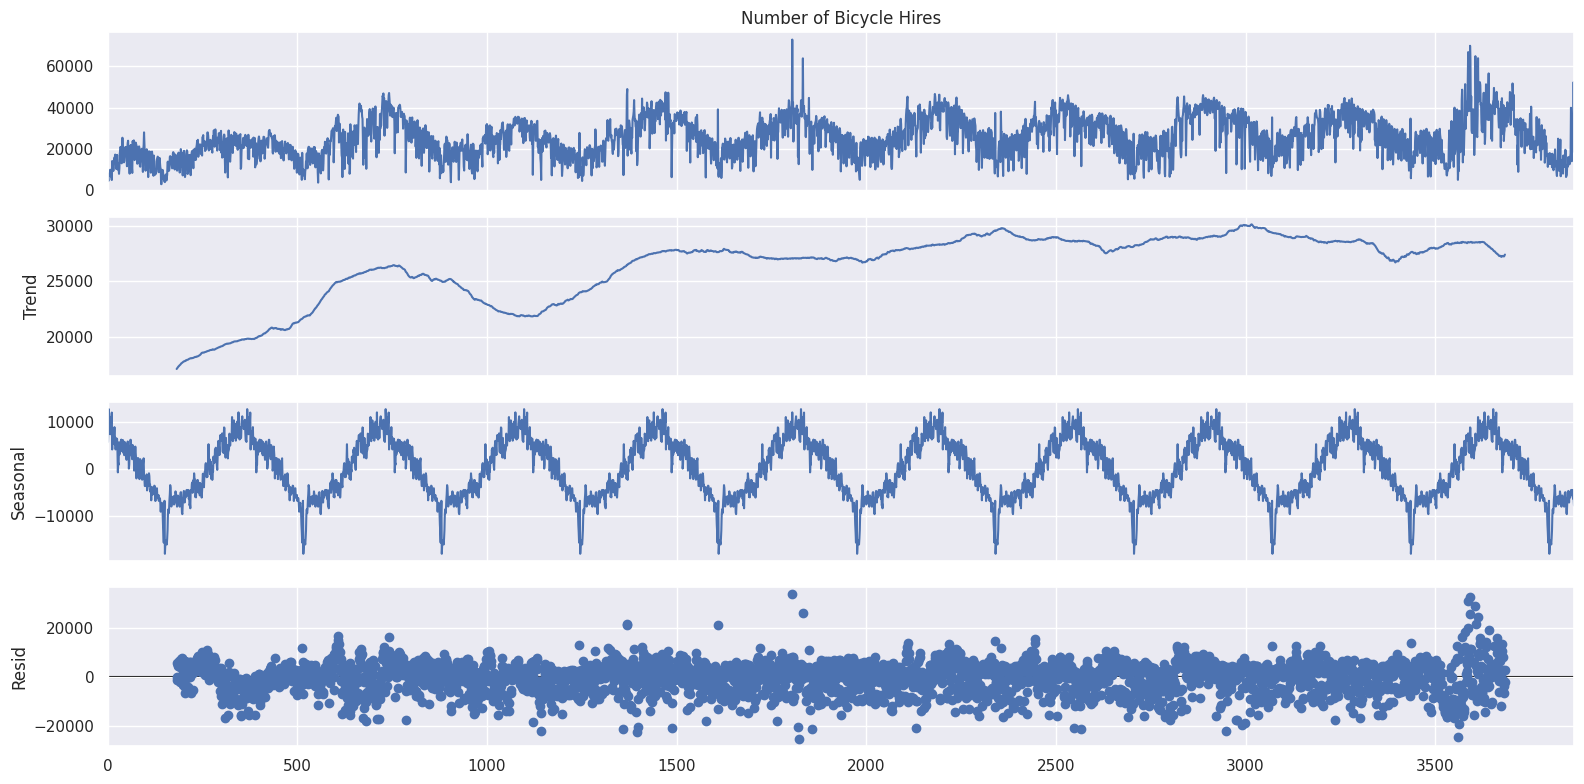

In [19]:
decompose_result = seasonal_decompose(
    x=daily_hires_history_df[DAILY_HIRED_BICYCLES_COL],
    model='additive',
    period=365
)
ax = decompose_result.plot()
plt.show();

As we may see from the plot, the seasonality of bicycle hires is very important and follows the logic above with the peaks during the summer months. However, the blue line on the last plot and a green one on the first show daily movements indicate that there seems to be another trend on the week level regardless of the season.

However, the general trend is not so noticeable as the seasonal one. At the very beginning, after the launch of the bike rental system, in the first 3-5 years, there was an increase from year to year in the number of bike rentals. However, in the last 3-4 years, even despite the COVID, the trend seems to have hit the ceiling. Perhaps new stations have ceased to open at the rental, or maybe this is the ceiling for demand in the current conditions. 

Let's explore these peaks on the plot closely and understand the reasons behind them.
For this purpose, I need to create some date-related features (also it helps filter data quickly), like seasons, months and also I will include holidays information from the UK Bank:

In [20]:
SEASONS = ["Winter", "Spring", "Summer", "Autumn"]


def month_no_to_season(month_no: int, seasons: List[str] = SEASONS) -> str:
    """
    Converts month num (starting from 1) to a season name
    # 1 -> winter
    # 2 -> winter
    # 3 -> spring
    # ...
    # 11 - autumn
    # 12 - winter
    """
    keep_idx = month_no % 12 // 3
    return seasons[keep_idx]


daily_hires_history_df = daily_hires_history_df.assign(
    **{
        WEEKDAY_COL: daily_hires_history_df[DAY_COL].dt.weekday,
        # holidays accoridng to the UK Bank
        IS_HOLIDAY_COL: daily_hires_history_df[DAY_COL].isin(holiday_dates),
        YEAR_COL: daily_hires_history_df[DAY_COL].dt.year,
        # columns with month number and name
        MONTH_NUM_COL: daily_hires_history_df[DAY_COL].dt.month,
        MONTH_COL: daily_hires_history_df[DAY_COL].dt.strftime("%b"),
        SEASON_COL: daily_hires_history_df[DAY_COL].dt.month.map(month_no_to_season),
        IS_WEEKEND_COL: daily_hires_history_df[DAY_COL].dt.weekday > 4,
    }
)

Let's take a look at the top 10 days with the most bikes hires:

In [21]:
(
    daily_hires_history_df
    .sort_values(DAILY_HIRED_BICYCLES_COL, ascending=False)
    .head(10)
    [[DAY_COL, WEEKDAY_COL, IS_HOLIDAY_COL, MONTH_COL]]
)

,Day,Day of week,Is UK holiday,Month
1805,2015-07-09,3,False,Jul
3592,2020-05-30,5,False,May
3587,2020-05-25,0,True,May
3606,2020-06-13,5,False,Jun
3613,2020-06-20,5,False,Jun
1833,2015-08-06,3,False,Aug
3593,2020-05-31,6,False,May
3607,2020-06-14,6,False,Jun
3641,2020-07-18,5,False,Jul
3586,2020-05-24,6,False,May


This table showed two peaks in 2015, and the rest of the dates in 2020 are weekends (Day of the week is 5 and 6 for Saturday and Sunday, respectively) in the warm months. Also, 2020-05-25 breaks this logic - it is Monday, but it is a holiday at the beginning of the COVID-19 lockdown (which was introduced on the 23rd of March).

I found out that tube strikes took place on both 9th of July 2015 and the 6th of August 2015 on each of those days. This also provides evidence that a significant proportion of bike usage was due to work commute. A tube strike on a working day (Thursday) would mean many people had to find alternatives to reach their work. It causes a significant increase in bike usage.

How typical is such a surge in the summer? It is logical to assume that people are more eager to ride and travel around the city on a bicycle in spring and summer. Let us check it out with monthly aggregations.

In [22]:
# Let's sum up all hires during each month
monthly_sum_agg_hires_df = (
    daily_hires_history_df
    .set_index(DAY_COL)
    .groupby([YEAR_COL, MONTH_COL])
    [DAILY_HIRED_BICYCLES_COL]
    .sum()
    .reset_index()
)

# and get mean for each month
monthly_mean_agg_hires_df = (
    monthly_sum_agg_hires_df
    .groupby(MONTH_COL)
    [DAILY_HIRED_BICYCLES_COL]
    .mean()
    .reset_index()
)

monthly_mean_agg_hires_df.sort_values(DAILY_HIRED_BICYCLES_COL,
                                      ascending=False, inplace=True)

In [23]:
monthly_mean_agg_hires_df.head(3)

,Month,Number of Bicycle Hires
5,Jul,995161.636364
6,Jun,981111.700000
1,Aug,960605.909091


All three summer months are, on average, the most popular, not surprisingly. However, what is the difference between the most active month of the year and the lowest? We have already seen on the general plot the high volatility of demand within one year, depending on the weather. 

In [24]:
monthly_mean_agg = monthly_mean_agg_hires_df[DAILY_HIRED_BICYCLES_COL].values
most_active_month = monthly_mean_agg_hires_df[MONTH_COL].values[0]
lowest_active_month = monthly_mean_agg_hires_df[MONTH_COL].values[-1]
perc_diff = round((monthly_mean_agg[0] / monthly_mean_agg[-1] - 1) * 100, 2)

print(f'The most active month (which is {most_active_month}) has, on average, '
      f'{perc_diff}% more bike hires than the lowest ({lowest_active_month}).')

The most active month (which is Jul) has, on average, 88.76% more bike hires than the lowest (Dec).


But is it such a big difference, and is it observed in Autumn or Spring? We will plot the distribution of daily bike rentals depending on the season and also select one of the last years, 2019, for consideration and comparison with general data.

## 3.2 Seasons comparison

In [25]:
hires_for_2019 = daily_hires_history_df[daily_hires_history_df[YEAR_COL] == 2019]

hires_for_2019.loc[:, SPECIFIC_YEAR_2019] = 'Year 2019 hires data'
daily_hires_history_df.loc[:, SPECIFIC_YEAR_2019] = 'General hires data'

violin_plot_data = pd.concat([daily_hires_history_df, hires_for_2019], axis=0, ignore_index=True)

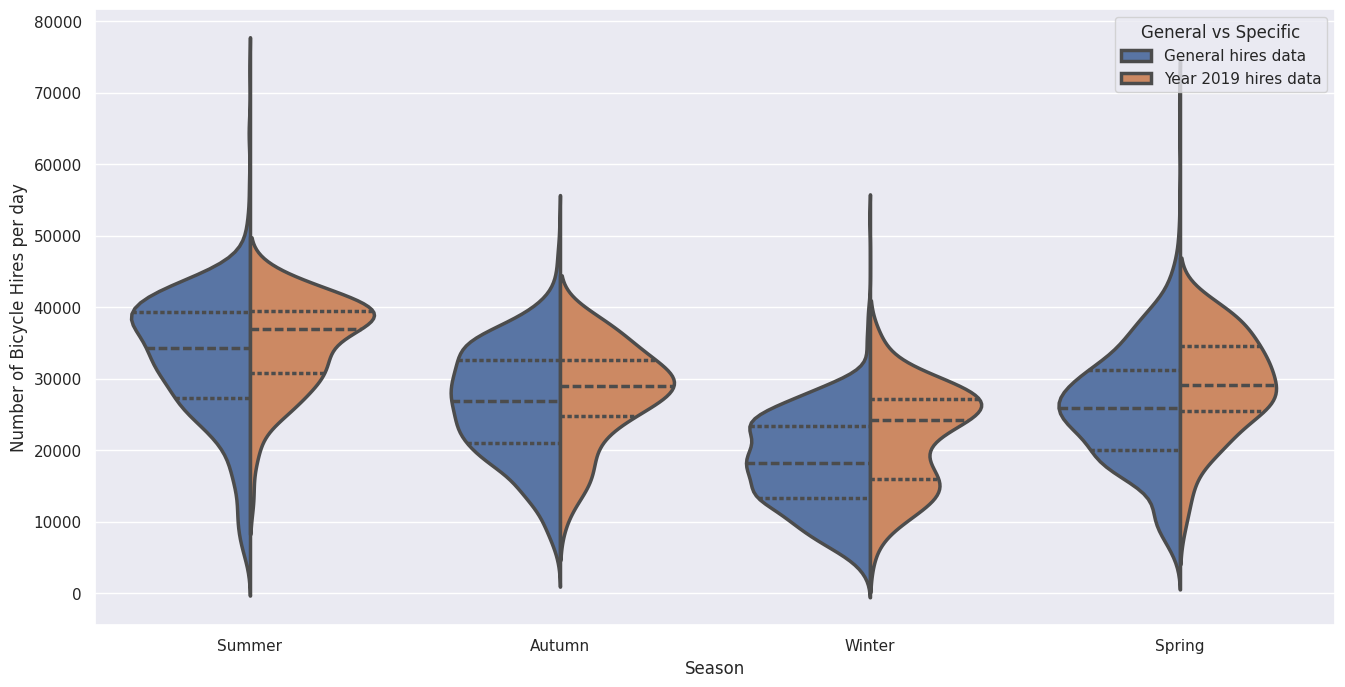

In [26]:
sns.violinplot(
    data=violin_plot_data,
    x=SEASON_COL,
    y=DAILY_HIRED_BICYCLES_COL,
    linewidth=2.5,
    split=True,
    inner="quartile",
    hue=SPECIFIC_YEAR_2019
)
plt.ylabel('Number of Bicycle Hires per day');

On the plot, small dotted lines indicate quartiles (lower 25, upper 75, respectively), and large dotted lines are the medians of the distribution of the number of rented bikes in that season.

In terms of the level of completed trips (on general data), Spring and Autumn are in the middle position between Winter and Summer and are on almost the same level with each other.

Interestingly, in 2019, a bimodal distribution can be observed in the winter season. Perhaps this is due to warm days in winter when people decide to ride a bike.

Let's check if the seasonal behavior has changed between 2019 and 2020. It is exciting to look at the start period of the COVID-19 lockdown.

In [27]:
## seasonal preparations: finding boundaries for each season
## to plot season names properly

seasonal_plot_slic_df = daily_hires_history_df[
    daily_hires_history_df[YEAR_COL]
    .isin([2019, 2020, 2021])
]


change_season = seasonal_plot_slic_df
change_season[SEASON_SHIFTED_COL] = (
    change_season[SEASON_COL]
    .shift(1)
    .fillna('')
)

change_season.loc[:, SEASON_HAS_CHANGED_COL] = (
    # because we shifted seasons by 1 day, we can compare neighbours
    # and detect border between seasons
    1 * (change_season[SEASON_SHIFTED_COL] != change_season[SEASON_COL])
)
change_season.loc[:, SEASON_HAS_CHANGED_COL] = (
    change_season[SEASON_HAS_CHANGED_COL]
    .cumsum()
    # after cumsum every season would have unique ID
)

change_season = (
    change_season
    .reset_index()
    # and we can group by that ID to get all rows for one season
    .groupby([SEASON_HAS_CHANGED_COL, SEASON_COL])
    [[DAY_COL]]
    .agg(['min','max'])
)

change_season.columns = [d[1] for d in change_season.columns]

change_season.loc[:, SEASON_DATE_MIDDLE_COL] = (
    change_season
    .apply(lambda x: x['min'] + (x['max'] - x['min'])/2 , axis = 1)
)

In [28]:
change_season.head(6).tail(3)

,,min,max,Season Middle Date
Season changed,Season,,,
4,Autumn,2019-09-01,2019-11-30,2019-10-16 00:00:00
5,Winter,2019-12-01,2020-02-29,2020-01-15 00:00:00
6,Spring,2020-03-01,2020-05-31,2020-04-15 12:00:00


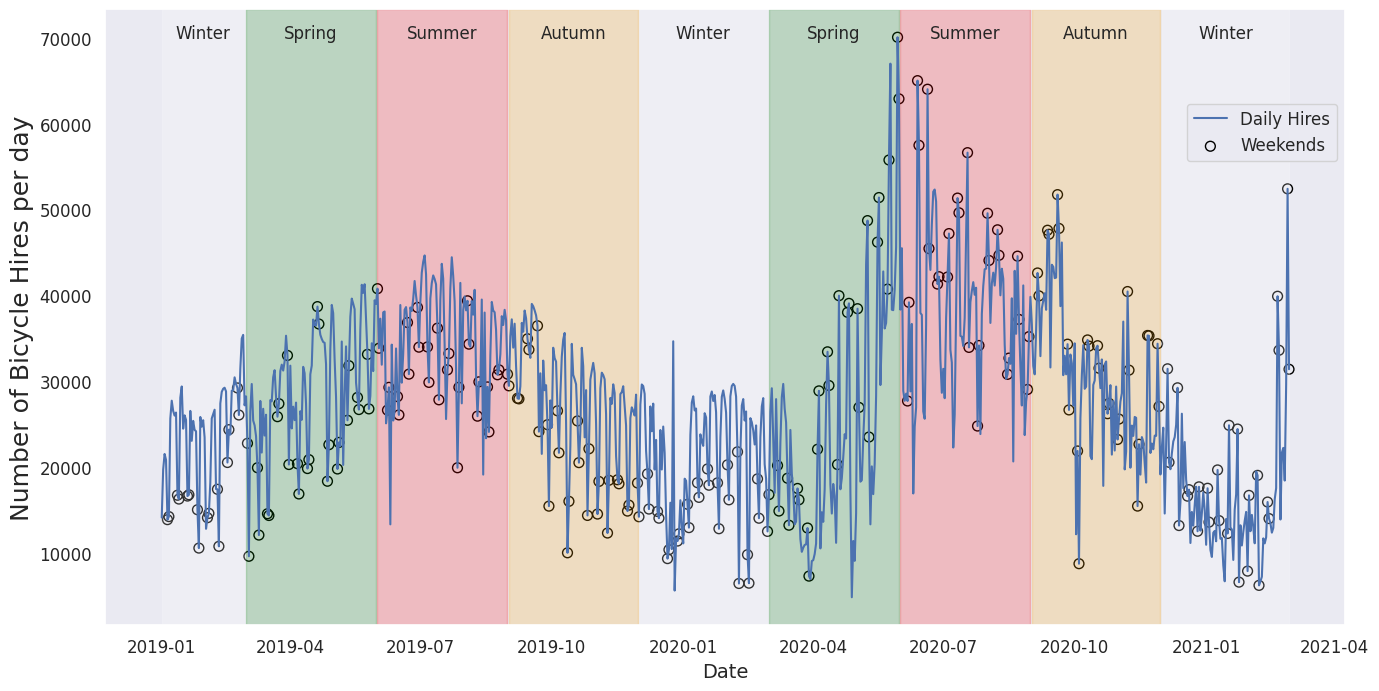

In [29]:
fig, ax = plt.subplots()

ax.plot(
    seasonal_plot_slic_df[DAY_COL],
    seasonal_plot_slic_df[DAILY_HIRED_BICYCLES_COL],
    label = 'Daily Hires'
)
weekends_mask = seasonal_plot_slic_df[WEEKDAY_COL] > 4
weekends_df = seasonal_plot_slic_df[weekends_mask]

ax.scatter(weekends_df[DAY_COL],
           weekends_df[DAILY_HIRED_BICYCLES_COL],
           label='Weekends',
           facecolors='none',
           edgecolors='black',
           s=50)

for i, v in change_season.reset_index().iterrows():
    if v[SEASON_COL] == SEASONS[0]:
        color = 'white'
    elif v[SEASON_COL] == SEASONS[1]:
        color = 'green'
    elif v[SEASON_COL] == SEASONS[2]:
        color = 'red'
    else:
        color = 'orange'

    ax.axvspan(
        *mdates.datestr2num([str(v['min']), str(v['max'])]),
        color=color,
        alpha=0.2
    )
    plt.text(
        x=v[SEASON_DATE_MIDDLE_COL],
        y=70000,
        s=v[SEASON_COL],
        size=12,
        rotation=0,
        ha="center"
    )

plt.xlabel('Date', fontsize=14)
plt.ylabel('Number of Bicycle Hires per day', fontsize=18)

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid()
plt.legend(fontsize=12, loc='right',bbox_to_anchor=(1,0.8))
plt.show()

Each black circle on the plot above marks weekends. Different seasons are painted in different colors.

It is accessible to notice that in 2019, most holidays - even in the summer - caused a drop in demand for bike rentals. However, in the spring of 2020, the trend changed - people began to rent more bikes on weekends than on weekdays (the circles begin to mark the peaks above the general demand line and not below).

In mid-spring, with the introduction of the lockdown, the demand for bicycles skyrocketed. People no longer wanted to ride in the crowd on the subway or buses and put themselves at risk of contracting the virus.

Perhaps because of this surge, the pattern of cycle hires has also changed. Let's look at monthly data on the average length of a bike ride.

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.


findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not fou

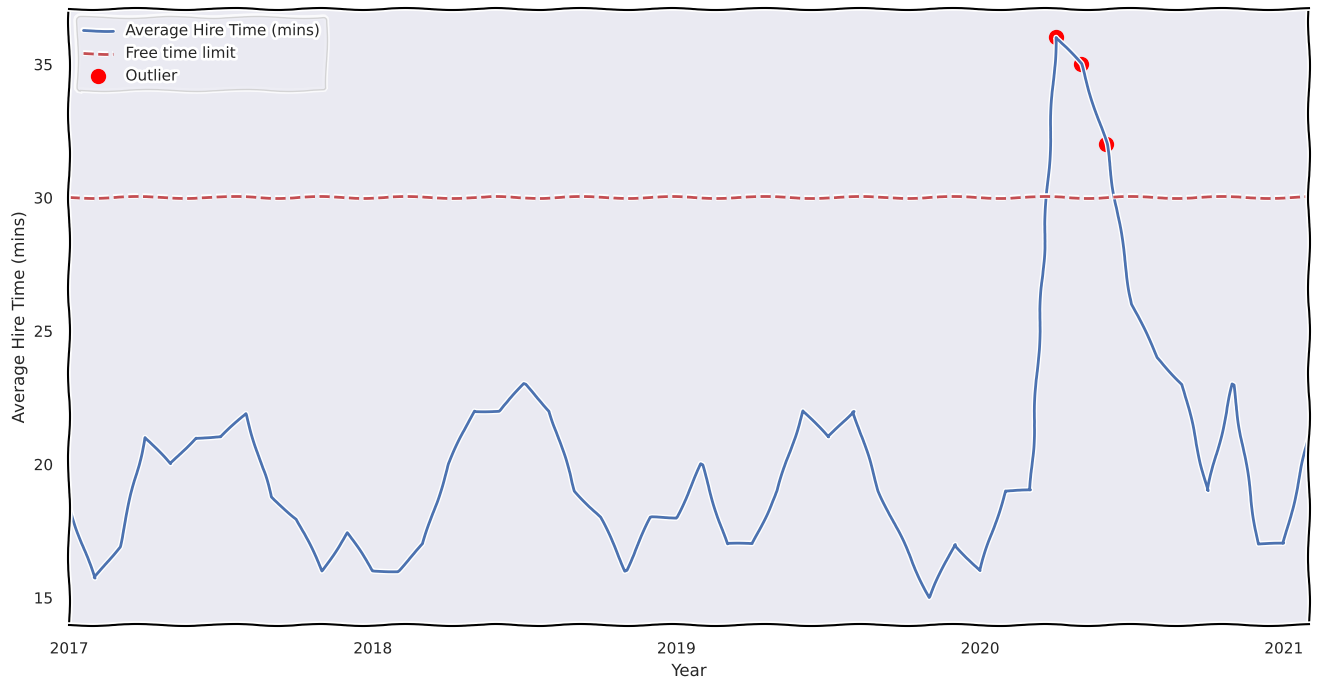

In [30]:
with plt.xkcd():
    monthly_avg_time_to_plot = monthly_avg_hire_time_df.tail(50).set_index(MONTH_COL)

    monthly_avg_time_to_plot[AVG_HIRE_TIME_COL].plot();
    plt.xlabel('Year');
    plt.ylabel('Average Hire Time (mins)');
    plt.axhline(y=30, color='r', linestyle='--', label='Free time limit');

    high_avg_hire_time_mask = monthly_avg_time_to_plot[AVG_HIRE_TIME_COL] > 30
    high_avg_hire_time_df = monthly_avg_time_to_plot[high_avg_hire_time_mask]

    plt.scatter(high_avg_hire_time_df.index,
               high_avg_hire_time_df[AVG_HIRE_TIME_COL],
               label='Outlier',
               facecolors='red',
               edgecolors='red',
               s=100)


    plt.legend();

In [31]:
monthly_avg_hire_time_df[monthly_avg_hire_time_df[AVG_HIRE_TIME_COL] > 30]

,Month,Average Hire Time (mins)
117,2020-04-01,36.0
118,2020-05-01,35.0
119,2020-06-01,32.0


The free limit for a bike in London is 30 minutes. Otherwise, a person has to pay 2£ for daily use. Over the entire existence of the system, the average value does not exceed this threshold. However, three months - April, May, June of 2020 - exceed the threshold. The pattern changed.

## 3.3 Intra-week seasonality

In addition to annual seasonality, at the very beginning, we noted intra-week seasonality. Furthermore, in the penultimate chart, we noticed that the division of consumption on weekdays and weekends has changed. Let us look at how the number of bikes per day correlates between different days of the week and also highlight the year 2020: 

In [32]:
hires_for_2020 = daily_hires_history_df[daily_hires_history_df[YEAR_COL] == 2020]

hires_for_2020.loc[:, SPECIFIC_YEAR_2020] = 'Year 2020 hires data'
daily_hires_history_df.loc[:, SPECIFIC_YEAR_2020] = 'General hires data'

weekdays_violin_plot_data = pd.concat([daily_hires_history_df, hires_for_2020], axis=0, ignore_index=True)

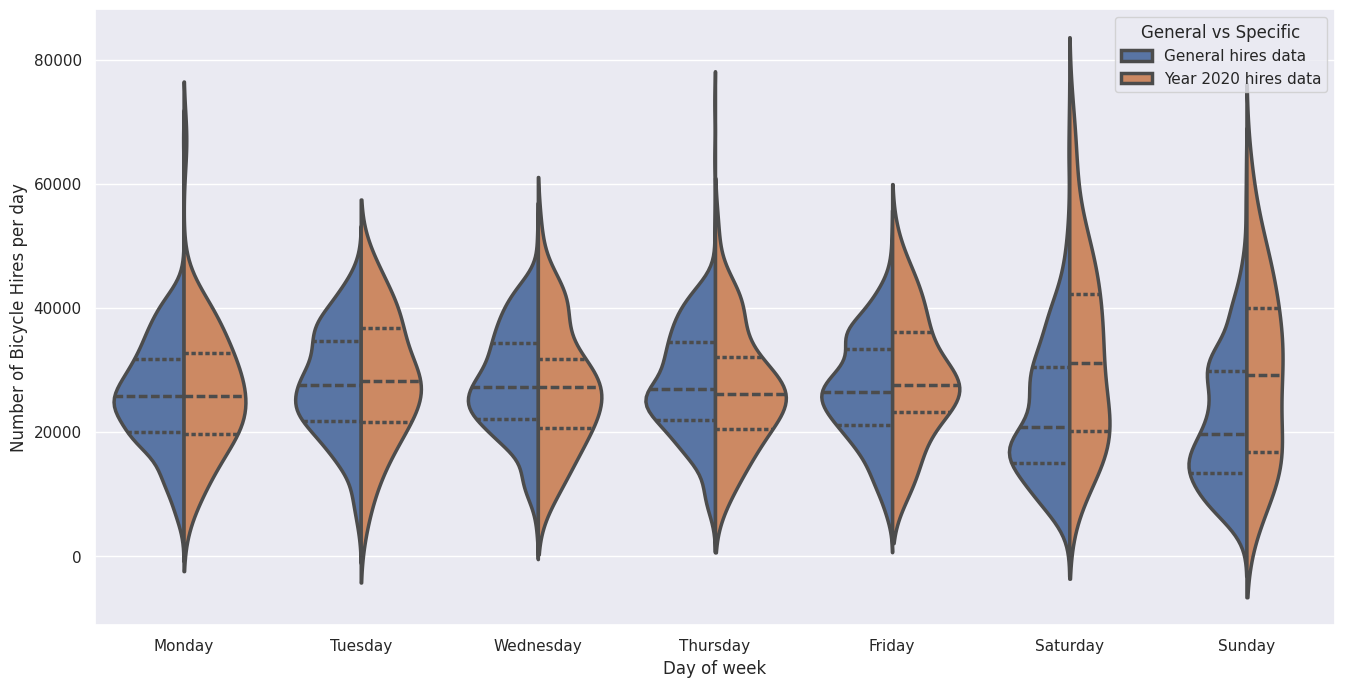

In [33]:
sns.violinplot(
    data=weekdays_violin_plot_data,
    x=WEEKDAY_COL,
    y=DAILY_HIRED_BICYCLES_COL,
    linewidth=2.5,
    split=True,
    inner="quartile",
    hue=SPECIFIC_YEAR_2020
)
plt.ylabel('Number of Bicycle Hires per day');
days_of_week = [
    'Monday', 'Tuesday', 'Wednesday', 'Thursday',
    'Friday', 'Saturday', 'Sunday'
]
plt.xticks(ticks=range(len(days_of_week)), labels=days_of_week);


Judging by the blue part of the graph, fewer bikes are hired on weekends than weekdays. At the same time, there is no significant difference in consumption within weekdays; people drive about the same on all days. However, if we consider the orange part - for 2020 - it becomes noticeable that people have begun to travel significantly more on weekends.

The distribution became flattered, but the dispersion increased - the distribution stretched along the axis. The most noticeable change is in the 75th quartile.

Let's look at the change in the ratio trend (between rentals on weekdays and weekends) over the past years.

In [34]:
# let's calculate proportion of bike hires between 
# weekdays and weekends
weekend_and_weekday_proportion_prep_df = (
    daily_hires_history_df
    [daily_hires_history_df.Year > 2015]
    .groupby([YEAR_COL, IS_WEEKEND_COL])
    [DAILY_HIRED_BICYCLES_COL]
    .mean()
)



In [35]:
# calc sum for normalize values in one year
year_agg_mean_daily_hires_df = (
    weekend_and_weekday_proportion_prep_df
    .reset_index()
    .groupby(YEAR_COL)
    [DAILY_HIRED_BICYCLES_COL]
    .sum()
    .rename(PROPORTION_SUM_YEAR_COL)
)
# add sum to the DF
weekend_and_weekday_proportion_prep_df = pd.merge(
    weekend_and_weekday_proportion_prep_df.reset_index(),
    year_agg_mean_daily_hires_df.reset_index()
)

# calc proportion
weekend_and_weekday_proportion_prep_df.loc[:, DAILY_HIRED_BICYCLES_COL] = (
    weekend_and_weekday_proportion_prep_df[DAILY_HIRED_BICYCLES_COL]
    / weekend_and_weekday_proportion_prep_df[PROPORTION_SUM_YEAR_COL]
)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not fo

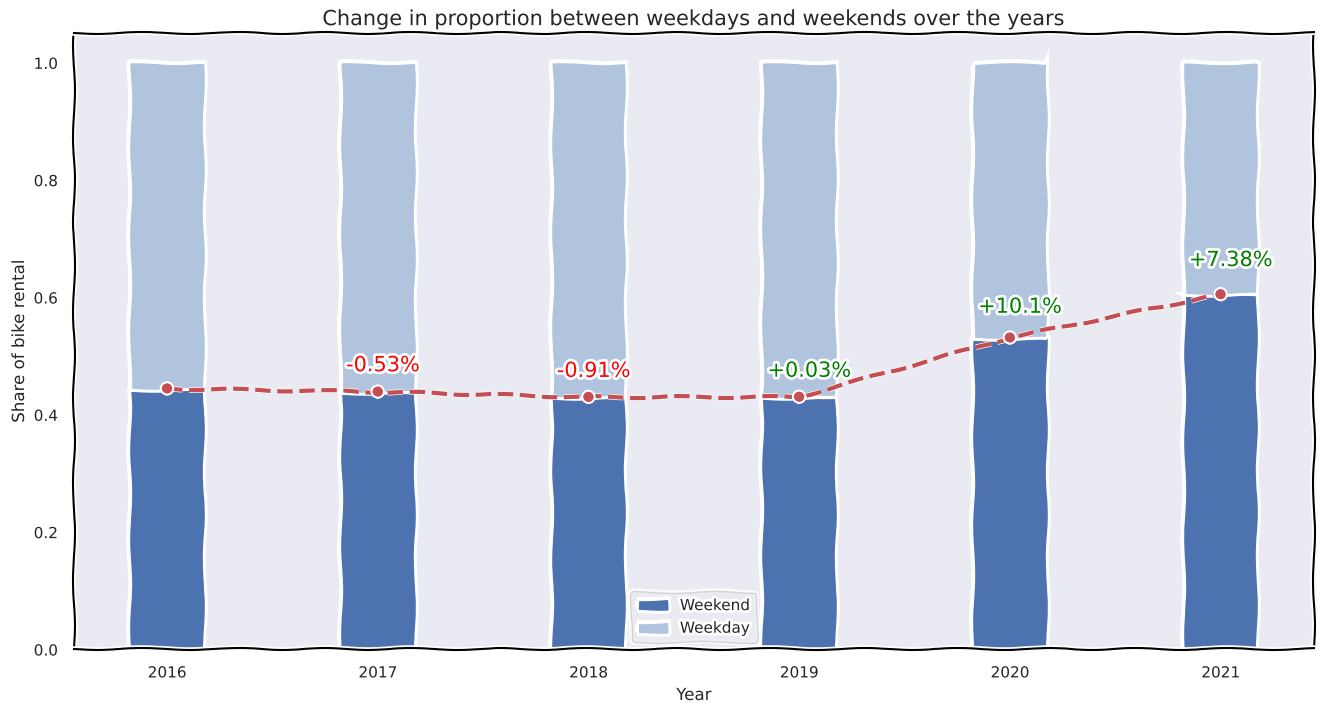

In [36]:
with plt.xkcd():
    fig, ax = plt.subplots()

    weekend_data = (
        weekend_and_weekday_proportion_prep_df
        [weekend_and_weekday_proportion_prep_df[IS_WEEKEND_COL]]
        [DAILY_HIRED_BICYCLES_COL]
    )

    weekday_data = (
        weekend_and_weekday_proportion_prep_df
        [~weekend_and_weekday_proportion_prep_df[IS_WEEKEND_COL]]
        [DAILY_HIRED_BICYCLES_COL]
    )

    years_to_plot = (
        weekend_and_weekday_proportion_prep_df
        [YEAR_COL]
        .drop_duplicates()
    )
    ax.bar(years_to_plot, weekend_data, label='Weekend', width=0.35)
    ax.bar(years_to_plot, weekday_data, label='Weekday', bottom=weekend_data, width=0.35, color='lightsteelblue')
    plt.xlabel('Year');
    plt.ylabel('Share of bike rental');
    plt.legend();
    plt.plot(years_to_plot, weekend_data, c='r',linewidth=3, marker='o', linestyle='dashed')

    percentage_diffs = (weekend_data - weekend_data.shift(1))
    for year, (cur_perc_diff, y_point) in enumerate(
            zip(percentage_diffs.values[1:],weekend_data[1:]),
            start=years_to_plot.values[1]):
        cur_color = 'red' if cur_perc_diff < 0 else 'green'
        cur_perc_diff = round(cur_perc_diff * 100, 2)
        cur_perc_diff_str = str(cur_perc_diff) if cur_perc_diff < 0 else '+' + str(cur_perc_diff)
        cur_perc_diff_str = cur_perc_diff_str + '%'

        plt.text(year-0.15, y_point * 1.08, cur_perc_diff_str, fontsize=15, color=cur_color);

    plt.title('Change in proportion between weekdays and weekends over the years', fontsize=15);

For the first four years of the period under review, there were no significant changes. The ratio of bike rentals on weekends and weekdays remained at 44%, but in 2020-2021 the situation changed dramatically, and now about 60% of trips are made on weekends.

## 3.4 Electrical Power high-level EDA

Let us end with some EDA for the second dataset, which will provide additional information for our main task - forecast the number of hired bikes. 

We can consider each type of electricity in a monthly slice and evaluate how their consumption has changed over time, what new types of electricity production have appeared, which, on the contrary, have disappeared.

In [37]:
electrical_power_for_plot_df = electrical_power_df.copy()

# remove all negative values, so we can sum up to 100%
# this affects only Pumped Hydro and Interconnections
# so we count only imported electricity as a "source"
electrical_power_for_plot_df.loc[:, GEN_SOURCES_LIST + INTERCONNECTIONS_LIST] = (
    electrical_power_for_plot_df
    [GEN_SOURCES_LIST + INTERCONNECTIONS_LIST]
    .clip(0)
)


In [38]:
# sum up all sources, this is a new total (100%)
electrical_power_for_plot_df.loc[:, TOTAL_NET_SUPPLY_COL] = (
    electrical_power_for_plot_df
    [GEN_SOURCES_LIST + INTERCONNECTIONS_LIST]
    .sum(axis=1)
)

# all interconnections are counted as one for the plot
electrical_power_for_plot_df.loc[:, INTERCONNETCIONS_SUM_COL] = (
    electrical_power_for_plot_df
    [INTERCONNECTIONS_LIST]
    .sum(axis=1)
)

electrical_power_for_plot_df = (
    electrical_power_for_plot_df
    [
        [DAY_COL, INTERCONNETCIONS_SUM_COL, TOTAL_NET_SUPPLY_COL]
        + GEN_SOURCES_LIST
    ]
)

# explode dataframe by type, so each row contains info about one type
power_info_df_to_plot = pd.melt(
    electrical_power_for_plot_df,
    id_vars=[DAY_COL, TOTAL_NET_SUPPLY_COL],
    value_vars=[INTERCONNETCIONS_SUM_COL] + GEN_SOURCES_LIST,
    var_name=ELECTR_TYPE_COL,
    value_name=ELECTR_AMOUNT_COL
)

In [39]:
# aggregate info about types by month, also include 
# total Net Supplies (for proportion estimation)
power_info_grouped_by_month_df = (
    power_info_df_to_plot
    .set_index(DAY_COL)
    .groupby([ELECTR_TYPE_COL, pd.Grouper(freq='m')])
    [[ELECTR_AMOUNT_COL, TOTAL_NET_SUPPLY_COL]]
    .sum()
    .reset_index()
)

In [40]:
# normalize amount of produced electricity by monthly sums
power_info_grouped_by_month_df.loc[:, ELECTR_AMOUNT_COL] = (
    power_info_grouped_by_month_df[ELECTR_AMOUNT_COL]
    / power_info_grouped_by_month_df[TOTAL_NET_SUPPLY_COL]
)

In [41]:
# collect data for plot, for every type 
# obtain a list of values to plot
type_to_monthly_hist = (
    power_info_grouped_by_month_df
    .groupby(ELECTR_TYPE_COL)
    [ELECTR_AMOUNT_COL]
    .apply(list)
)

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
findfont: Font family 'Humor Sans' not found.
findfont: Font family 'Comic Neue' not found.
findfont: Font family 'Comic Sans MS' not found.
findfont: Font family 'xkcd' not found.
findfont: Font family 'xkcd Script' not found.
f

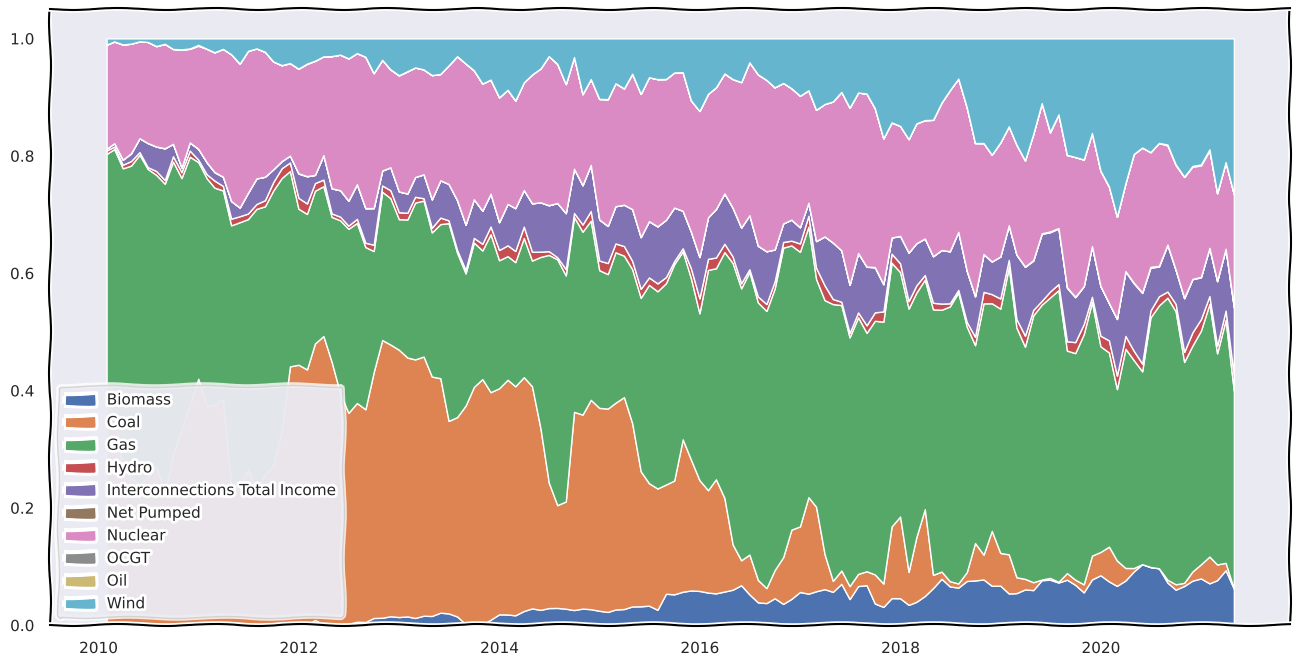

In [42]:
with plt.xkcd():
    dates_to_plot = power_info_grouped_by_month_df[DAY_COL].drop_duplicates()

    plt.stackplot(
        dates_to_plot,
        labels=type_to_monthly_hist.index,
        *type_to_monthly_hist.values
    );
    plt.legend(loc='lower left');

The first thing that immediately catches the eye is that since 2015, Britain has gradually reduced the level of electricity production based on coal, thus making electricity generation more environmentally friendly. Initially, electricity generation from gas decreased, but after switching from coal, gas took over the lost part and its share increased. Every year, an increasing share is occupied by electricity generated with the help of biomass.

Also, the share of electricity produced with the help of a renewable source, the wind, is systematically increasing. A solid share of approximately 18% is occupied by electricity from nuclear power plants.

The share of hydropower against the general background is not so large. Approximately 10% of the UK's electricity comes from interconnections with neighboring countries.

## 3.5 Other ideas for EDA

Hypotheses and ideas that can be further investigated:
- which countries are the primary consumers or exporters of energy?
- how did the monthly distribution change over the years? Are there any significant changes in proportion?
- how do holidays affect demand - how much more demand on average than on weekends or in general?
- how did significant events (other than COVID, for example, the prince's wedding or something else) affect bikes?
- what happened to the demand for bikes during the period of maximum wind power generation? Did demand drop?
- how does the average rental time change during the year?
- how strong is the seasonality of the wind, and how do other sources change at this time? What compensates?

# 4. ML models on TFL dataset

In order to predict the number of rented bikes, it is necessary to understand on what horizon we intend to predict and how the prediction will be built - one day or immediately for the entire period.

I cannot imagine why a forecast with 1-2 day horizon might be needed in this case. During this time, new bicycle stations cannot be installed, a large number of bicycles cannot be repaired (if the number of bicycles is ready for work is insufficient). Furthermore, if we find out that demand will fall, what benefit will it bring? After all, we cannot transfer bicycles to another city in one day, and bicycle rent stations cannot be used in any other way.

Based on these arguments, forecasting for at least a week seems logical. However, a horizon of 1 or 3 months is even more suitable (to predict for the new season, to understand whether there is a significant difference from last year and whether it is necessary to prepare for an increase in demand). Moreover, we do not see data for each subsequent day when forecasting. That is, information on energy generation in the future will not be available.

For weather (=energy production) information to somehow get into the model and be considered in the prediction, we can add two groups of parameters related to electricity - consumption seven days ago or consumption on the same date a year ago. When preparing the dataset, I will reveal this idea in more detail below.

In the work below, we take the prediction horizon as a month, or to be more precise, four full weeks. For the test sample, on which the final comparison of metrics should be made, we will cut off the month from the end of the dataset (the whole of February). Although it is expected to be anomalous since COVID is still present as a factor, the data will already contain information about people's behavior regarding bike rental from 2020 - the model should easily predict this.

Since this is not a machine learning competition, and the goal is not to get the most fine-tuned model, no selection of model hyperparameters will be performed (especially since the Prophet model is good enough out-of-box, opposite the gradient boosting algorithm, according to devs). The metrics will be calculated for validation, and the test part is introduced for potential future comparison with other models.

We will use the expanding window mechanism with a constant size of the validation set for cross-validation. On the one hand, we have many years of data (10+). On the other hand, we will have the entire history available for prediction in the real world. Changing the training dataset size by a year or two should not significantly affect trained models, while it would be right to choose the model that better utilizes the entire data set.

Let us choose MAE and sMAPE as metrics for prediction estimation. MAE was chosen instead of MSE because we do not want to overfit on outliers (like tube strike ones) and do not directly consider many factors (weather, breakdowns, local features in areas). sMAPE is expressed as a percentage, which is easier to understand and does not depend on demand spikes (the error for 5000 bikes in summer and winter, when demand differs by almost a factor of two, should be different).

In [43]:
from collections import defaultdict
from typing import Dict, Optional, Tuple

import numpy as np
import prophet
from sktime.forecasting.model_selection import ExpandingWindowSplitter
from sktime.performance_metrics.forecasting import (
    MeanAbsoluteError, MeanAbsolutePercentageError)
from statsmodels.tsa.stattools import adfuller

In [44]:
ONE_FOLD_SIZE_IN_DAYS = 28  # 4 weeks
N_VAL_FOLDS = 5

In [45]:
## Additional columns, created in the process
HOLIDAY_COL = 'holiday'
DS_COL = 'ds'
TARGET_COL = 'y'
PREDS_PROPHET_COL = 'yhat'

PROPHET_WEEKLY_COL = 'weekly'

In [46]:
n_days_in_dataset = daily_hires_history_df[DAY_COL].shape[0]
# N_VAL_FOLDS for validation and the last one for test (final metrics)
initial_window_size = n_days_in_dataset - ONE_FOLD_SIZE_IN_DAYS * (N_VAL_FOLDS + 1) 

splitter = ExpandingWindowSplitter(
    fh=ONE_FOLD_SIZE_IN_DAYS,
    initial_window=initial_window_size,
    step_length=ONE_FOLD_SIZE_IN_DAYS,
)

In [47]:
# split our dataset to 6 folds, train parts and test part
all_splits = list(splitter.split(daily_hires_history_df[DAY_COL]))
train_cv_splits = all_splits[:-1]
test_split = all_splits[-1]


In [48]:
# let us take middle split train data to make first sanity checks
indices_to_analyze = train_cv_splits[-3][0]
train_df_to_analize = daily_hires_history_df.loc[indices_to_analyze]

First, we need to understand whether it is worth transforming the time series. Let us check the series for stationarity by the Dickey-Fuller test.

In [49]:
def get_af_pval(inp_seq) -> float:
    p_value = adfuller(inp_seq)[1]
    return p_value

df_pval = get_af_pval(train_df_to_analize[DAILY_HIRED_BICYCLES_COL])
print(f'Dickey-Fuller test P-value: {df_pval}')

Dickey-Fuller test P-value: 0.0017751730539649914


This means that the time series is stationary, which means it is homoscedastic.

We will take Prophet from Facebook as a base model, as it is a reasonably good baseline and contains several cool features.

In [50]:
uk_holidays_df_to_prophet = uk_holidays_df.rename({HOLIDAYS_DATE_COL: DS_COL}, axis=1)
uk_holidays_df_to_prophet[HOLIDAY_COL] = HOLIDAY_COL


In [51]:
sample_train_df = (
    daily_hires_history_df.iloc[indices_to_analyze, :]
    .rename({DAY_COL: DS_COL, DAILY_HIRED_BICYCLES_COL: TARGET_COL}, axis=1)
    [[DS_COL, TARGET_COL]]
)

val_start_idx = indices_to_analyze[-1] + 1
val_end_idx = val_start_idx + ONE_FOLD_SIZE_IN_DAYS


sample_val_df = (
    daily_hires_history_df.iloc[val_start_idx: val_end_idx, :]
    .rename({DAY_COL: DS_COL, DAILY_HIRED_BICYCLES_COL: TARGET_COL}, axis=1)
    [[DS_COL, TARGET_COL]]
)

We will perform a training on one fold without cross-validation for a general visual assessment.

In [52]:
def train_and_predict_prophet_model(
    model: prophet.Prophet,
    train_df: pd.DataFrame,
    valid_df: pd.DataFrame    
):
    model.fit(train_df)
    preds = model.predict(model.make_future_dataframe(ONE_FOLD_SIZE_IN_DAYS))
    return preds

In [53]:
base_model = prophet.Prophet(
    holidays=uk_holidays_df_to_prophet,
    daily_seasonality=False,
)

sample_preds_prophet = train_and_predict_prophet_model(
    base_model,
    sample_train_df,
    sample_val_df
)

19:46:15 - cmdstanpy - INFO - Chain [1] start processing
19:46:16 - cmdstanpy - INFO - Chain [1] done processing


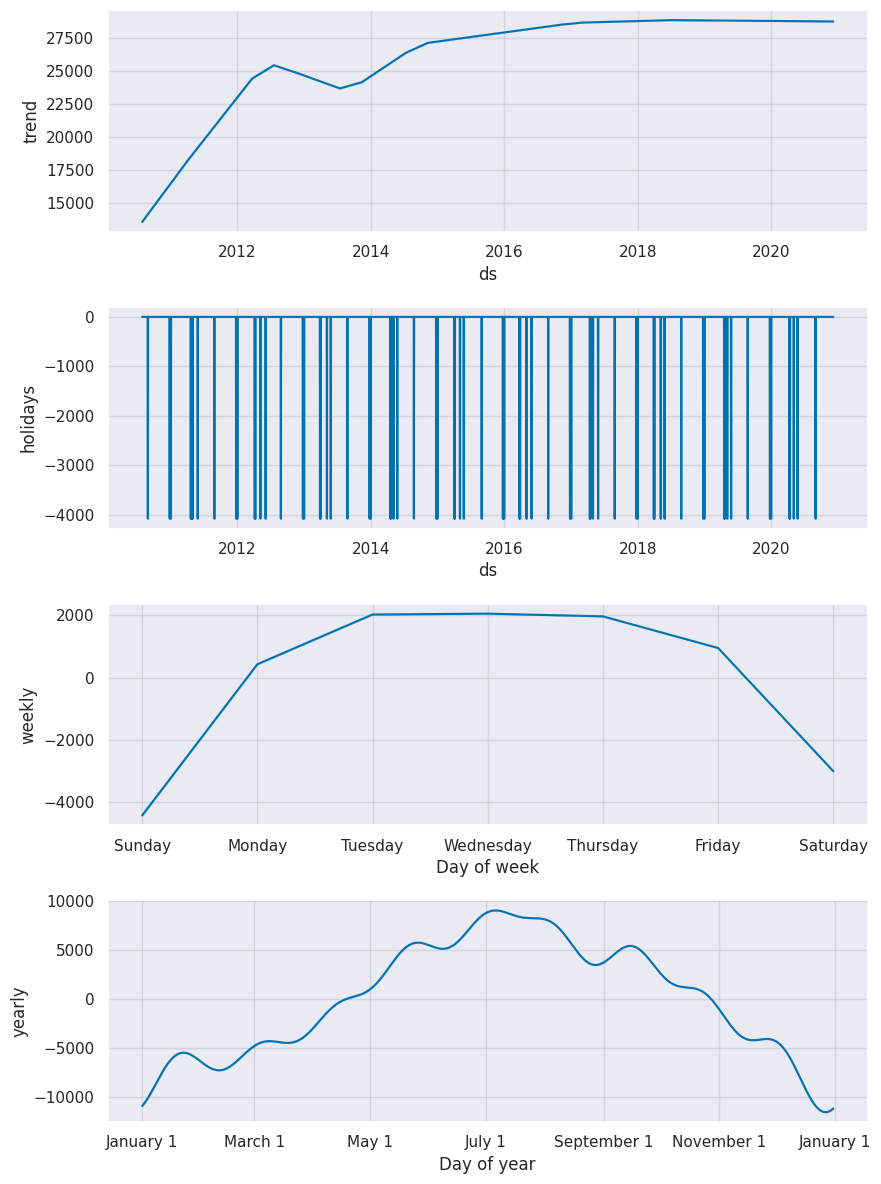

In [54]:
base_model.plot_components(sample_preds_prophet);

It can be seen that the weekly seasonality does not correspond to the trend that appeared in 2020 due to COVID. Will this cause problem for the model?


In [55]:
def plot_ts_preds_and_gts(
    train_series: pd.Series,
    val_series: pd.Series,
    preds_series: pd.Series
):
    plt.plot(train_series, label='Bike hires history');
    plt.plot(preds_series, color='r', label='Predictions');
    plt.plot(val_series, label='GT val', color='green');
    plt.ylabel('Number of hired bikes');
    plt.xlabel('Date');
    plt.legend();

In [56]:
# plot only small amount of training data, only 365//4 days
train_to_plot = sample_train_df.set_index(DS_COL).tail(365//4)[TARGET_COL]
val_to_plot = sample_val_df.set_index(DS_COL)[TARGET_COL]

preds_to_plot = sample_preds_prophet.set_index(DS_COL).tail(ONE_FOLD_SIZE_IN_DAYS)[PREDS_PROPHET_COL]


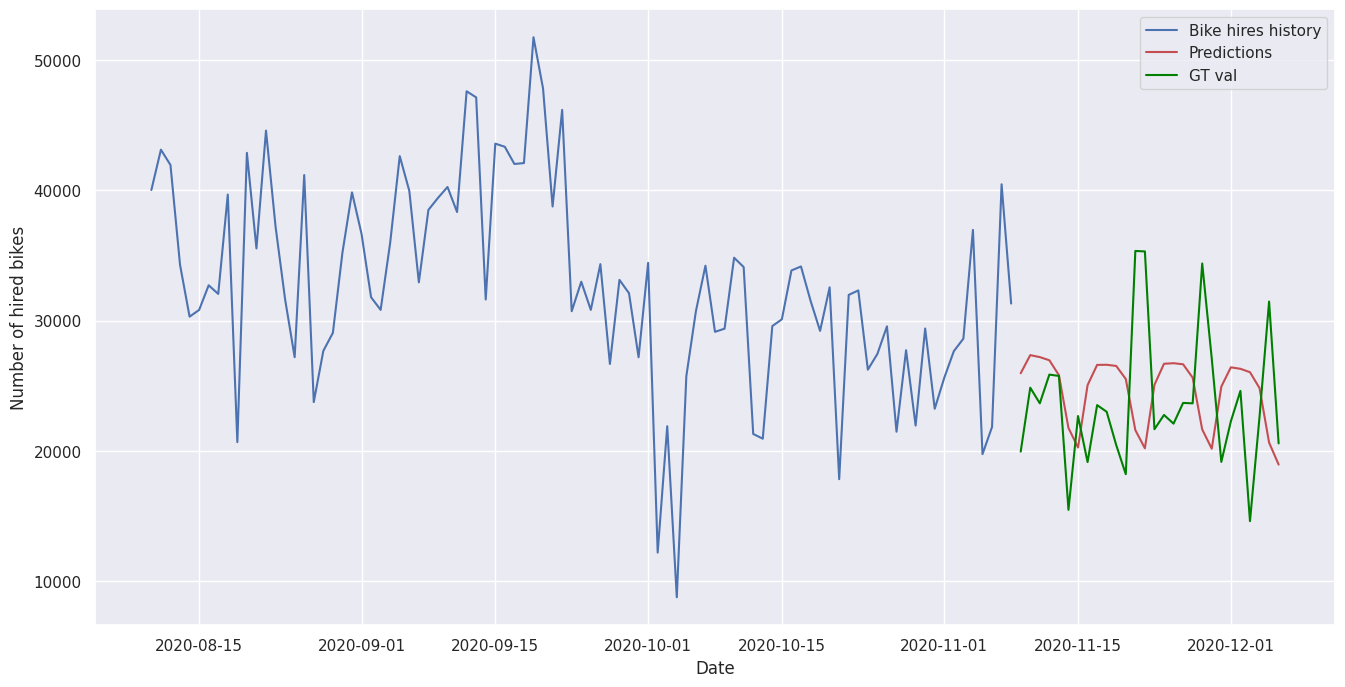

In [57]:
plot_ts_preds_and_gts(train_to_plot, val_to_plot, preds_to_plot)

It can be seen with the naked eye that the model does not follow into the internal seasonality, and therefore the error of the model must be significant.
Also, there is a gap on the graph when moving to the test part, so let us make a simple sanity check that not a single day was lost between them.

In [58]:
train_to_plot.tail(2)

ds
2020-11-07    40467
2020-11-08    31315
Name: y, dtype: int64

In [59]:
preds_to_plot.head(2)

ds
2020-11-09    25966.854943
2020-11-10    27357.717879
Name: yhat, dtype: float64

The training data ends on 2020-11-08, and the validation part starts on 2020-11-09, so everything is fine.
Let us calculate the metrics.

In [60]:
def calc_metrics(gt, pred):
    mae_metric = MeanAbsoluteError()
    smape_metric = MeanAbsolutePercentageError(symmetric=True)
    
    mae_val = mae_metric(gt, pred)
    smape_val = smape_metric(gt, pred)
    return {'MAE': mae_val, 'SMAPE': smape_val}

In [61]:
calc_metrics(val_to_plot, preds_to_plot)

{'MAE': 5392.165053770165, 'SMAPE': 0.22269428884152395}

It is difficult to assess whether this is good or bad, but according to the graph with a forecast for only one fold, it was clear that the error was too large.

Since the change in intra-week seasonality occurred with COVID-19 in March 2020, we can try to train the model only on the latest up-to-date data and check what happens:

19:46:22 - cmdstanpy - INFO - Chain [1] start processing
19:46:22 - cmdstanpy - INFO - Chain [1] done processing


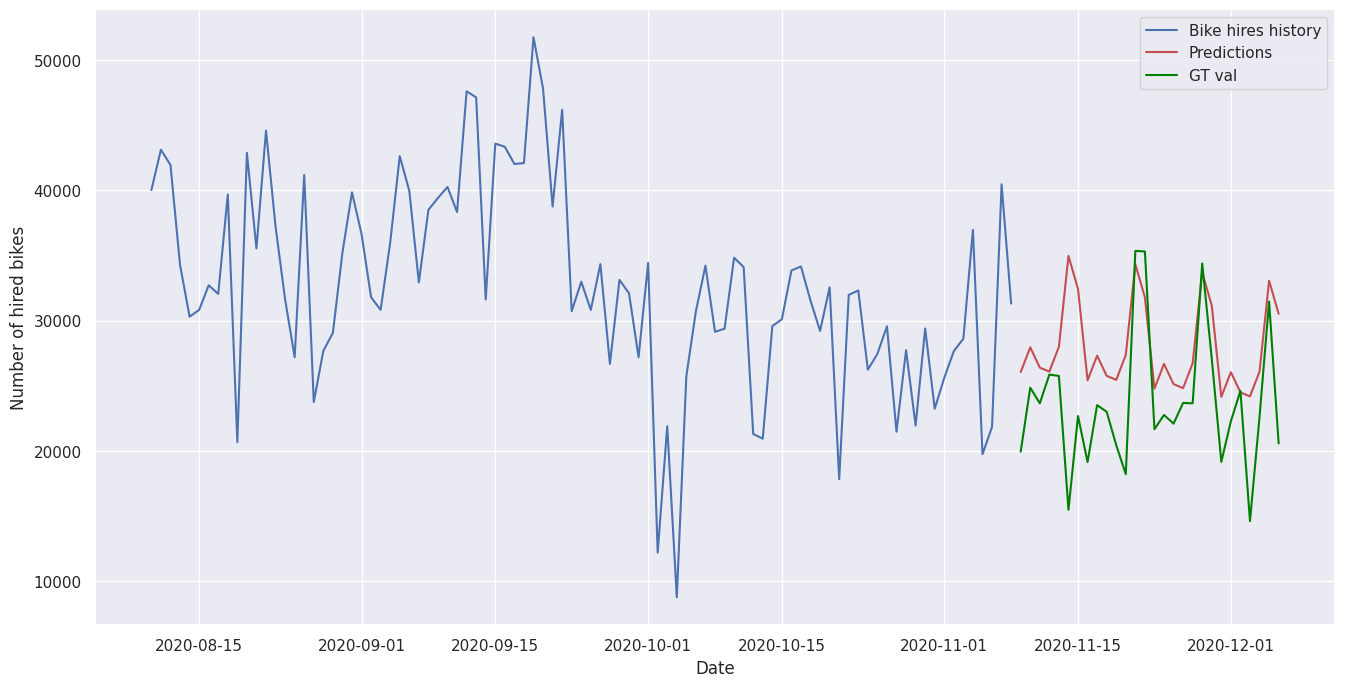

In [62]:
base_model_short = prophet.Prophet(
    holidays=uk_holidays_df_to_prophet,
    daily_seasonality=False,
)

sample_train_df_short = sample_train_df[sample_train_df[DS_COL] > '2020-03-01']

sample_preds_prophet_short = train_and_predict_prophet_model(
    base_model_short,
    sample_train_df_short,
    sample_val_df
)


preds_to_plot_short = (
    sample_preds_prophet_short
    .set_index(DS_COL)
    .tail(ONE_FOLD_SIZE_IN_DAYS)
    [PREDS_PROPHET_COL]
)


plot_ts_preds_and_gts(train_to_plot, val_to_plot, preds_to_plot_short)

In [63]:
calc_metrics(val_to_plot, preds_to_plot_short)

{'MAE': 4559.702550222546, 'SMAPE': 0.1865528328892398}

Both visually and metric-wise, it turns out that the model has become better. However, the previous model, trained on all data, is not used in any way.

I see two ways to solve this problem. The first is to take another model, for which it is clear how to manage seasonality (ARIMA / SARIMA) based on the latest observations (no more than a year or two ago), the second is to train Prophet on all data, but after that, redefine the internal weekly seasonality based on the model trained on a small sample.

Let us try the second option - we can take the model that we trained earlier and apply the weekly seasonality from the last model to it:

In [64]:
# remove weekly from predictions
preds_without_weekly = (
    sample_preds_prophet[PREDS_PROPHET_COL]
    - sample_preds_prophet[PROPHET_WEEKLY_COL]
)

# only for last 28 days - validation part
preds_without_weekly = preds_without_weekly.tail(ONE_FOLD_SIZE_IN_DAYS)

# add new weekly seasonality from short model (only COVID-specific)
weekly_seas_to_add = sample_preds_prophet_short[PROPHET_WEEKLY_COL].tail(ONE_FOLD_SIZE_IN_DAYS).values
preds_corrected = preds_without_weekly + weekly_seas_to_add

sample_preds_prophet[PREDS_PROPHET_COL] = preds_corrected

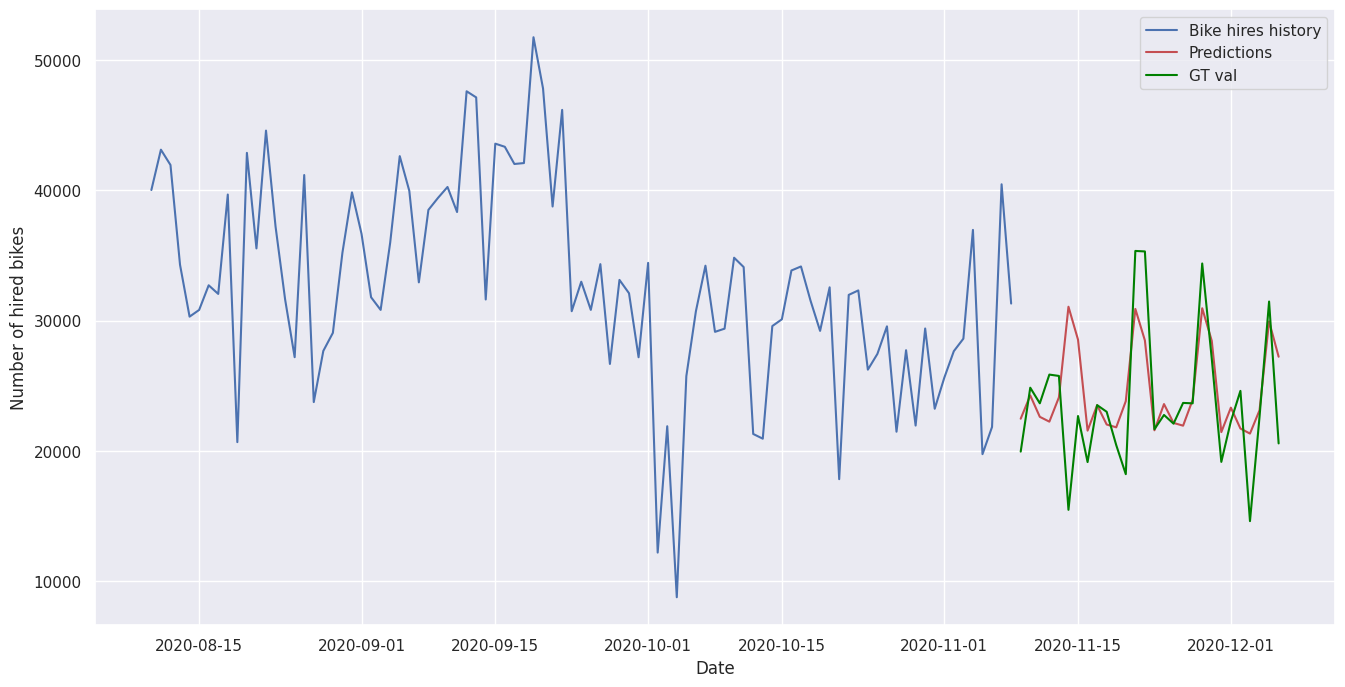

In [65]:
preds_to_plot = sample_preds_prophet.set_index(DS_COL).tail(ONE_FOLD_SIZE_IN_DAYS)[PREDS_PROPHET_COL]
plot_ts_preds_and_gts(train_to_plot, val_to_plot, preds_to_plot)

In [66]:
calc_metrics(val_to_plot, preds_to_plot)

{'MAE': 2925.151677728965, 'SMAPE': 0.12268026401457992}

For one fold, it can be noted that there is a significant improvement over our final prediction. Also, it has an adjusted weekly seasonality. It accurately predicts daily changes, and on the other hand, the model is trained on ten years of history and understands the general trend and monthly changes. In order to finally make sure that the method works, we will conduct a full validation on all folds:

In [67]:
def setup_train_and_val_df(
    daily_hires_history_df: pd.DataFrame,
    cur_cv_split
) -> Tuple[pd.DataFrame, pd.DataFrame]:
    train_indices = cur_cv_split[0]
    train_df = (
        daily_hires_history_df.iloc[train_indices, :]
        .rename({DAY_COL: DS_COL, DAILY_HIRED_BICYCLES_COL: TARGET_COL}, axis=1)
        [[DS_COL, TARGET_COL]]
    )

    val_start_idx = train_indices[-1] + 1
    val_end_idx = val_start_idx + ONE_FOLD_SIZE_IN_DAYS
    val_df = (
        daily_hires_history_df.iloc[val_start_idx: val_end_idx, :]
        .rename({DAY_COL: DS_COL, DAILY_HIRED_BICYCLES_COL: TARGET_COL}, axis=1)
        [[DS_COL, TARGET_COL]]
    )
    return train_df, val_df

def fix_seasonality_from_two_preds(
    base_preds: pd.DataFrame,
    seas_preds: pd.DataFrame
) -> pd.DataFrame:
    # replace weekly component of predictions from the local model
    preds_without_weekly = (
        base_preds[PREDS_PROPHET_COL].values
        - base_preds[PROPHET_WEEKLY_COL].values
    )

    weekly_seas_to_add = seas_preds[PROPHET_WEEKLY_COL].values
    preds_corrected = preds_without_weekly + weekly_seas_to_add

    base_preds[PREDS_PROPHET_COL] = preds_corrected
    return base_preds

In [68]:
def calc_cv_metrics_prophet(
    train_cv_splits,
    daily_hires_df: pd.DataFrame,
    holidays_df: Optional[pd.DataFrame] = None,
    do_weekly_correction: bool = True,
    do_general_prediction: bool = True,
    weekly_correction_start_date: str = '2020-03-01',
) -> Dict[str, float]:
    err_msg = ('At least one of `do_weekly_correction` and '
               '`do_general_prediction` should be True!')
    assert do_weekly_correction or do_general_prediction, err_msg
    metrics = defaultdict(list)
    for cur_cv_split in train_cv_splits:
        train_df, val_df = setup_train_and_val_df(daily_hires_df, cur_cv_split)
        if do_general_prediction: # base model on all data
            base_model = prophet.Prophet(
                holidays=holidays_df,
                daily_seasonality=False,
            )
            preds_prophet = train_and_predict_prophet_model(
                base_model,
                train_df,
                val_df
            ).tail(ONE_FOLD_SIZE_IN_DAYS)
        
        if do_weekly_correction: # weekly model on COVID-data
            seas_train_df = train_df[train_df[DS_COL] > weekly_correction_start_date]
            seas_model = prophet.Prophet(
                holidays=holidays_df,
                daily_seasonality=False,
                yearly_seasonality=False
            )
            seas_preds_prophet = train_and_predict_prophet_model(
                seas_model,
                seas_train_df,
                val_df
            ).tail(ONE_FOLD_SIZE_IN_DAYS)

        if do_general_prediction and do_weekly_correction:
            preds_prophet = fix_seasonality_from_two_preds(
                base_preds=preds_prophet,
                seas_preds=seas_preds_prophet
            )
        elif do_weekly_correction:
            preds_prophet = seas_preds_prophet
            
            
        val_to_calc_metrics = val_df.set_index(DS_COL)[TARGET_COL]
        preds_to_calc_metrics = preds_prophet.set_index(DS_COL)[PREDS_PROPHET_COL]
        cur_split_metrics = calc_metrics(val_to_calc_metrics, preds_to_calc_metrics)
        for metric_key in cur_split_metrics:
            metrics[metric_key].append(cur_split_metrics[metric_key])
    
    for metric_key in metrics:
        metrics[metric_key] = np.mean(metrics[metric_key])
    return dict(metrics)
    

Let us make three runs, repeating the logic of previous experiments:

In [69]:
prophet_metrics_w_correction = calc_cv_metrics_prophet(
    train_cv_splits,
    daily_hires_history_df,
    uk_holidays_df_to_prophet
)

19:46:25 - cmdstanpy - INFO - Chain [1] start processing
19:46:26 - cmdstanpy - INFO - Chain [1] done processing
19:46:28 - cmdstanpy - INFO - Chain [1] start processing
19:46:28 - cmdstanpy - INFO - Chain [1] done processing
19:46:29 - cmdstanpy - INFO - Chain [1] start processing
19:46:30 - cmdstanpy - INFO - Chain [1] done processing
19:46:31 - cmdstanpy - INFO - Chain [1] start processing
19:46:32 - cmdstanpy - INFO - Chain [1] done processing
19:46:32 - cmdstanpy - INFO - Chain [1] start processing
19:46:34 - cmdstanpy - INFO - Chain [1] done processing
19:46:35 - cmdstanpy - INFO - Chain [1] start processing
19:46:35 - cmdstanpy - INFO - Chain [1] done processing
19:46:36 - cmdstanpy - INFO - Chain [1] start processing
19:46:37 - cmdstanpy - INFO - Chain [1] done processing
19:46:39 - cmdstanpy - INFO - Chain [1] start processing
19:46:39 - cmdstanpy - INFO - Chain [1] done processing
19:46:40 - cmdstanpy - INFO - Chain [1] start processing
19:46:41 - cmdstanpy - INFO - Chain [1]

In [70]:
prophet_metrics_wo_correction = calc_cv_metrics_prophet(
    train_cv_splits,
    daily_hires_history_df,
    uk_holidays_df_to_prophet,
    do_weekly_correction=False
)

19:46:44 - cmdstanpy - INFO - Chain [1] start processing
19:46:45 - cmdstanpy - INFO - Chain [1] done processing
19:46:47 - cmdstanpy - INFO - Chain [1] start processing
19:46:48 - cmdstanpy - INFO - Chain [1] done processing
19:46:50 - cmdstanpy - INFO - Chain [1] start processing
19:46:52 - cmdstanpy - INFO - Chain [1] done processing
19:46:53 - cmdstanpy - INFO - Chain [1] start processing
19:46:55 - cmdstanpy - INFO - Chain [1] done processing
19:46:57 - cmdstanpy - INFO - Chain [1] start processing
19:46:58 - cmdstanpy - INFO - Chain [1] done processing


In [71]:
prophet_metrics_weekly_only = calc_cv_metrics_prophet(
    train_cv_splits,
    daily_hires_history_df,
    uk_holidays_df_to_prophet,
    do_general_prediction=False
)

19:47:00 - cmdstanpy - INFO - Chain [1] start processing
19:47:00 - cmdstanpy - INFO - Chain [1] done processing
19:47:00 - cmdstanpy - INFO - Chain [1] start processing
19:47:00 - cmdstanpy - INFO - Chain [1] done processing
19:47:01 - cmdstanpy - INFO - Chain [1] start processing
19:47:01 - cmdstanpy - INFO - Chain [1] done processing
19:47:02 - cmdstanpy - INFO - Chain [1] start processing
19:47:02 - cmdstanpy - INFO - Chain [1] done processing
19:47:02 - cmdstanpy - INFO - Chain [1] start processing
19:47:02 - cmdstanpy - INFO - Chain [1] done processing


In [72]:
metrics_df = pd.DataFrame([
    prophet_metrics_w_correction,
    prophet_metrics_wo_correction,
    prophet_metrics_weekly_only
])
metrics_df['Model Alias'] = [
    'With Weekly Seasonality correction',
    'Without Weekly Seasonality correction',
    'Only Weekly Seasonality (1 year data)'
]

In [73]:
metrics_df.sort_values('SMAPE')

,MAE,SMAPE,Model Alias
0,5528.735573,0.252343,With Weekly Seasonality correction
2,6348.110671,0.265069,Only Weekly Seasonality (1 year data)
1,6010.264057,0.276797,Without Weekly Seasonality correction


The table shows that the proposed prediction refinement logic led to an improvement in the metrics.

But can the metric be further improved by adding energy generation data?

# 5. ML models on TFL + Electrical Power dataset

It seems that of all sources of energy, wind power can directly correlate with the weather (wind speed) and thus help predict bike hires. The total energy consumption from all sources can also indirectly affect - in cold weather, electricity consumption probably increases. I also tried other features, including the energy import-export by interconnections. However, they worsened or did not change the result.

In [74]:
electrical_power_for_prophet = electrical_power_df.copy()

# all interconnections are counted as one for the plot
# electrical_power_for_prophet.loc[:, INTERCONNETCIONS_SUM_COL] = (
#     electrical_power_for_prophet
#     [INTERCONNECTIONS_LIST]
#     .sum(axis=1)
# )

electrical_power_for_prophet = (
    electrical_power_for_prophet
    [[
        DAY_COL, WIND_COL, TOTAL_NET_SUPPLY_COL
    ]]
    .rename({DAY_COL: DS_COL}, axis=1)
)

features_cols = list(set(electrical_power_for_prophet.columns) - set([DS_COL]))

In [75]:
# update functions, so they can work with new features
def train_and_predict_prophet_model_w_features(
    model: prophet.Prophet,
    train_df: pd.DataFrame,
    valid_df: pd.DataFrame,
    features_df,
    features_columns: List[str]
):
    model.fit(train_df)
    future_df = model.make_future_dataframe(ONE_FOLD_SIZE_IN_DAYS)
    future_df = pd.merge(future_df, features_df, how='left', on=DS_COL)
    for feat_col in features_columns:
        # fill values from the previous year
        future_df[feat_col] = future_df[feat_col].shift(365)
    future_df = future_df.dropna()
    preds = model.predict(future_df)
    return preds


def train_general_model(train_df, val_df, holidays_df, features_df, features_columns):
    base_model = prophet.Prophet(
        holidays=holidays_df,
        daily_seasonality=False,
    )
    for feat_name in features_columns:
        base_model.add_regressor(feat_name)
        # fill values from the previous year
        train_df[feat_name] = train_df[feat_name].shift(365)
    train_df = train_df.dropna()

    preds_prophet = train_and_predict_prophet_model_w_features(
        base_model,
        train_df,
        val_df,
        features_df,
        features_columns
    ).tail(ONE_FOLD_SIZE_IN_DAYS)
    return preds_prophet

def train_weekly_model(train_df, val_df, holidays_df, weekly_correction_start_date):
    seas_train_df = train_df[train_df[DS_COL] > weekly_correction_start_date]
    seas_model = prophet.Prophet(
        holidays=holidays_df,
        daily_seasonality=False,
        yearly_seasonality=False
    )
    seas_preds_prophet = train_and_predict_prophet_model(
        seas_model,
        seas_train_df,
        val_df
    ).tail(ONE_FOLD_SIZE_IN_DAYS)
    return seas_preds_prophet


In [76]:
def calc_cv_metrics_prophet_w_features(
    train_cv_splits,
    daily_hires_df: pd.DataFrame,
    features_df: pd.DataFrame,
    features_columns: List[str],
    holidays_df: Optional[pd.DataFrame] = None,
    do_weekly_correction: bool = True,
    do_general_prediction: bool = True,
    weekly_correction_start_date: str = '2020-03-01',
) -> Dict[str, float]:
    err_msg = ('At least one of `do_weekly_correction` and '
               '`do_general_prediction` should be True!')
    assert do_weekly_correction or do_general_prediction, err_msg
    metrics = defaultdict(list)
    features_df = features_df[[DS_COL] + features_columns]
    for cur_cv_split in train_cv_splits:
        train_df, val_df = setup_train_and_val_df(daily_hires_df, cur_cv_split)
        # add features to train
        train_df = pd.merge(train_df, features_df, how='left', on=DS_COL)
        if do_general_prediction: # base model on all data
            preds_prophet = train_general_model(train_df, val_df, holidays_df,
                                                features_df, features_columns,)
        
        if do_weekly_correction: # weekly model on COVID-data
            seas_preds_prophet = train_weekly_model(train_df, val_df,
                                                    holidays_df,
                                                    weekly_correction_start_date)
            
        if do_general_prediction and do_weekly_correction:
            preds_prophet = fix_seasonality_from_two_preds(
                base_preds=preds_prophet,
                seas_preds=seas_preds_prophet
            )
        elif do_weekly_correction:
            preds_prophet = seas_preds_prophet
            
            
        val_to_calc_metrics = val_df.set_index(DS_COL)[TARGET_COL]
        preds_to_calc_metrics = preds_prophet.set_index(DS_COL)[PREDS_PROPHET_COL]
        cur_split_metrics = calc_metrics(val_to_calc_metrics, preds_to_calc_metrics)
        for metric_key in cur_split_metrics:
            metrics[metric_key].append(cur_split_metrics[metric_key])
    
    for metric_key in metrics:
        metrics[metric_key] = np.mean(metrics[metric_key])
    return dict(metrics)
    

In [77]:
prophet_metrics_w_features = calc_cv_metrics_prophet_w_features(
    train_cv_splits,
    daily_hires_history_df,
    electrical_power_for_prophet,
    features_cols,
    uk_holidays_df_to_prophet,
)

prophet_metrics_w_features['Model Alias'] = 'With additional features'

19:47:03 - cmdstanpy - INFO - Chain [1] start processing
19:47:05 - cmdstanpy - INFO - Chain [1] done processing
19:47:06 - cmdstanpy - INFO - Chain [1] start processing
19:47:06 - cmdstanpy - INFO - Chain [1] done processing
19:47:07 - cmdstanpy - INFO - Chain [1] start processing
19:47:08 - cmdstanpy - INFO - Chain [1] done processing
19:47:09 - cmdstanpy - INFO - Chain [1] start processing
19:47:10 - cmdstanpy - INFO - Chain [1] done processing
19:47:10 - cmdstanpy - INFO - Chain [1] start processing
19:47:12 - cmdstanpy - INFO - Chain [1] done processing
19:47:14 - cmdstanpy - INFO - Chain [1] start processing
19:47:14 - cmdstanpy - INFO - Chain [1] done processing
19:47:14 - cmdstanpy - INFO - Chain [1] start processing
19:47:16 - cmdstanpy - INFO - Chain [1] done processing
19:47:18 - cmdstanpy - INFO - Chain [1] start processing
19:47:18 - cmdstanpy - INFO - Chain [1] done processing
19:47:19 - cmdstanpy - INFO - Chain [1] start processing
19:47:20 - cmdstanpy - INFO - Chain [1]

In [79]:
metrics_df = metrics_df._append(prophet_metrics_w_features, ignore_index=True)
metrics_df.sort_values('SMAPE')

,MAE,SMAPE,Model Alias
3,5363.903501,0.246024,With additional features
0,5528.735573,0.252343,With Weekly Seasonality correction
2,6348.110671,0.265069,Only Weekly Seasonality (1 year data)
1,6010.264057,0.276797,Without Weekly Seasonality correction


As a result, we see that the addition of energy production slightly improves the prediction quality. Similar features with a month lag (30 days instead of 365) worsened the metrics.

I am sure that there is a way to continue to "extract" information from the data by applying models that better take into account the interaction of features - for example, gradient boosting (also adding features from time series models - values with lags, day of the week, is it weekend, and so on), and also directly adding weather predictions data from an external dataset.